# Imports and hyperparameters

In [1]:
import copy
import wandb
import os

import lightning as l
import torch
import torchvision
import torchmetrics
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

from lightly.data import LightlyDataset
from lightly.loss.vicreg_loss import VICRegLoss
from lightly.models.modules.heads import VICRegProjectionHead
from lightly.transforms.vicreg_transform import VICRegTransform
from lightly.models.utils import (
    batch_shuffle,
    batch_unshuffle,
    deactivate_requires_grad,
    update_momentum,
)
from lightly.transforms import utils
from torch.optim import SGD, Adam

In [2]:
wandb.login()

wandb: Currently logged in as: czifrus-hanna (czhanna-wandb). Use `wandb login --relogin` to force relogin


True

In [3]:
num_workers = os.cpu_count()
batch_size = 512
memory_bank_size = 4096
seed = 1
max_epochs = 100
data_dir = '../data/'
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
path_to_train = data_dir + "100-bird-species/train/"
path_to_valid = data_dir + "100-bird-species/valid/"
path_to_test = data_dir + "100-bird-species/test/"

In [5]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(path_to_train)
num_classes = len(dataset.classes)
print(num_classes)

525


In [6]:
l.seed_everything(seed)

Seed set to 1


1

# Datasets

In [7]:
train_vicreg_transform = VICRegTransform(
    input_size=32,
    gaussian_blur=0.0,
)

train_classifier_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [8]:
dataset_train_vicreg = LightlyDataset(input_dir=path_to_train, transform=train_vicreg_transform)

dataset_train_classifier = LightlyDataset(
    input_dir=path_to_train, transform=train_classifier_transforms
)

dataset_valid = LightlyDataset(input_dir=path_to_valid, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

In [9]:
dataloader_train_vicreg = torch.utils.data.DataLoader(
    dataset_train_vicreg,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_train_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

# VICReg class 
SSL-method with pretrained resnet18 backbone

In [10]:
class VICReg(l.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = VICRegProjectionHead(
            input_dim=512,
            hidden_dim=2048,
            output_dim=2048,
            num_layers=4,
        )
        self.criterion = VICRegLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("vicreg_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = Adam(self.parameters(), lr=0.06)
        return optim

# Classifier class
Defining one classification layer after the backbone

In [11]:
class Classifier(l.LightningModule):
    def __init__(self, backbone, freeze, num_classes):
        super().__init__()
        self.backbone = backbone

        if freeze:
            # freeze the backbone
            deactivate_requires_grad(backbone)

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(512, num_classes)

        self.firstTime = True

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        if self.firstTime:
            self.firstTime = False
            print(type(x))
            print(x)
            print(type(y))
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("classifier_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        self.validation_step_outputs.append((num, correct))
        return num, correct

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            total_num = 0
            total_correct = 0
            for num, correct in self.validation_step_outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)
            self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        return (y_hat, y)

    def configure_optimizers(self):
        optim = Adam(self.fc.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

# Training

You can load the trained models after each training cell by specifying the appropriate path and commenting out the required lines

## VICReg training

In [ ]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="VICReg", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='vicreg_loss',
    mode='min',
    dirpath = './models/',
    filename = 'best_model_vicreg',
)

ssl_model = VICReg()
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(model=ssl_model, train_dataloaders=dataloader_train_vicreg)

wandb.finish()

In [ ]:
# Before running change ckpt_path to the correct one
# ckpt_path = "models/best_model_vicreg.ckpt"

# ssl_model = VICReg()
# ssl_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict'])

## Classifier training

In [ ]:
def train_classifier(wandb_name, filename, backbone, freeze, max_eps):
    wandb_logger = l.pytorch.loggers.WandbLogger(
        name=wandb_name, project="Self-supervised learning in-the-wild"
    )
    callback = l.pytorch.callbacks.ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        dirpath = './models/',
        filename = filename,
    )

    classifier = Classifier(backbone, freeze, num_classes)
    trainer = l.pytorch.Trainer(
        max_epochs=max_eps, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]

    )
    trainer.fit(classifier, dataloader_train_classifier, dataloader_valid)

    wandb.finish()
    
    return classifier

### With ssl pretrained backbone and frozen weights

In [ ]:
model_ssl_frozen = train_classifier("Classifier ssl frozen backbone", 
                                    'best_model_with_ssl_frozen', 
                                    ssl_model.backbone, True, max_epochs)

In [12]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_ssl_frozen.ckpt"

ssl_model = VICReg()
model_ssl_frozen = Classifier(ssl_model.backbone, True, num_classes)
model_ssl_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### With ssl pretrained backbone and NOT frozen weights

In [ ]:
model_ssl_not_frozen = train_classifier("Classifier ssl not frozen backbone",
                                        'best_model_with_ssl_not_frozen',
                                        ssl_model.backbone, False, max_epochs)

In [13]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_ssl_not_frozen.ckpt"

ssl_model = VICReg()
model_ssl_not_frozen = Classifier(ssl_model.backbone, False, num_classes)
model_ssl_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### Without SSL, but pretrained backbone with frozen weights

In [14]:
# Defining the pretrained backbone
# Running this cell is also required for loading from checkpoint

resnet_pt = torchvision.models.resnet18(pretrained=True)
backbone_pt = nn.Sequential(*list(resnet_pt.children())[:-1])

In [ ]:
model_pretrained_frozen = train_classifier("Classifier pretrained and frozen backbone",
                                           'best_model_with_pretrained_frozen',
                                           backbone_pt, True, max_epochs)

In [15]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_pretrained_frozen.ckpt"

model_pretrained_frozen = Classifier(backbone_pt, False, num_classes)
model_pretrained_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### Without SSL, but pretrained backbone with NOT frozen weights

In [ ]:
model_pretrained_not_frozen = train_classifier("Classifier pretrained and not frozen backbone",
                                               'best_model_with_pretrained_not_frozen',
                                               backbone_pt, False, max_epochs)

In [16]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 4 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_pretrained_not_frozen.ckpt"

model_pretrained_not_frozen = Classifier(backbone_pt, False, num_classes)
model_pretrained_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### With untrained backbone

In [17]:
# Defining the untrained backbone
# Running this cell is also required for loading from checkpoint

resnet_npt = torchvision.models.resnet18(pretrained=False)
backbone_npt = nn.Sequential(*list(resnet_npt.children())[:-1])

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_untrained = train_classifier("Classifier untrained backbone",
                                   'best_model_with_untrained',
                                   backbone_npt, False, max_epochs)

In [18]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_npt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_untrained.ckpt"

model_untrained = Classifier(backbone_npt, False, num_classes)
model_untrained.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

# Evaluation

## Accuracy on test dataset

In [19]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="Classifier", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='val_acc',
    mode='max'
)
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)

models = [model_ssl_frozen, model_ssl_not_frozen, model_pretrained_frozen, model_pretrained_not_frozen, model_untrained]
titles = ["SSL and frozen backbone",
         "SSL and not frozen backbone",
         "Pretrained and frozen backbone",
         "Pretrained and not frozen backbone",
         "With untrained backbone"]

accuracies = []
losses = []
for model in models:
    model.eval()
    test = trainer.test(model, dataloader_test)
    accuracies.append(test[0]["test_acc"])
    losses.append(test[0]["test_loss"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: |                                                                                       | 0/? [00:00<…

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 65. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.00800000037997961    │
│         test_loss         │     6.083162307739258     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.007619047537446022    │
│         test_loss         │     6.079869747161865     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.024000000208616257    │
│         test_loss         │     5.937129497528076     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.029333332553505898    │
│         test_loss         │     6.06565523147583      │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.005333333276212215    │
│         test_loss         │     6.299389362335205     │
└───────────────────────────┴───────────────────────────┘

C:\Users\Hanna\AppData\Local\Temp\ipykernel_15076\3470356060.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(titles, rotation=45, ha='right')
C:\Users\Hanna\AppData\Local\Temp\ipykernel_15076\3470356060.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(titles, rotation=45, ha='right')


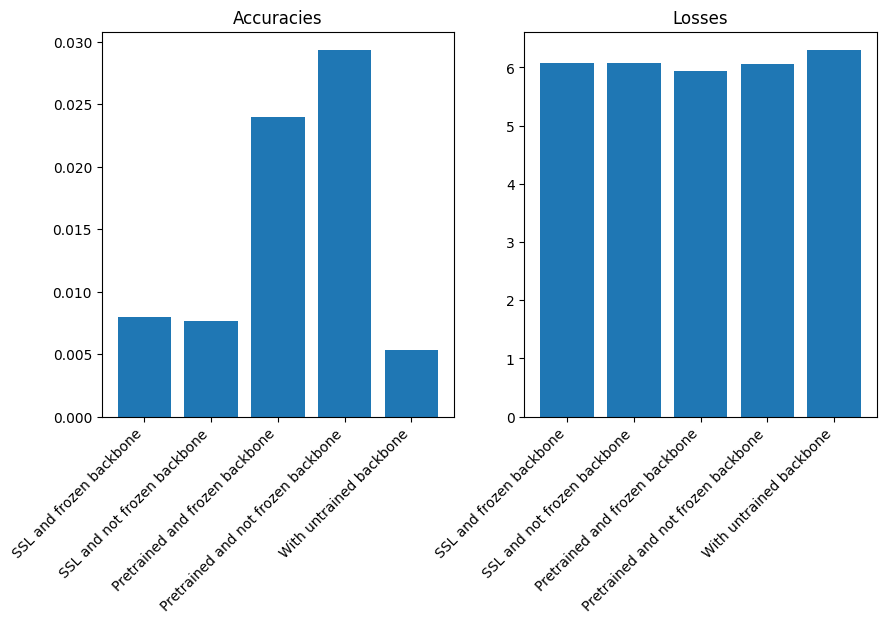

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(titles, accuracies)
ax1.set_title('Accuracies')
ax1.set_xticklabels(titles, rotation=45, ha='right')
ax2.bar(titles, losses)
ax2.set_title('Losses')
ax2.set_xticklabels(titles, rotation=45, ha='right')

plt.show()

## Confusion matrix

In [21]:
def evaluate_model(model, dataloader, num_classes):
    confusion_matrix_metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
    model.eval()
    with torch.no_grad():
        for y_hat, y in trainer.predict(model, dataloader):
            confusion_matrix_metric(y_hat.softmax(dim=-1), y)
    confusion_matrix = confusion_matrix_metric.compute()
    return confusion_matrix

confusion_matrices = []
for model in models:
    confusion_matrices.append(evaluate_model(model, dataloader_test, num_classes))

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

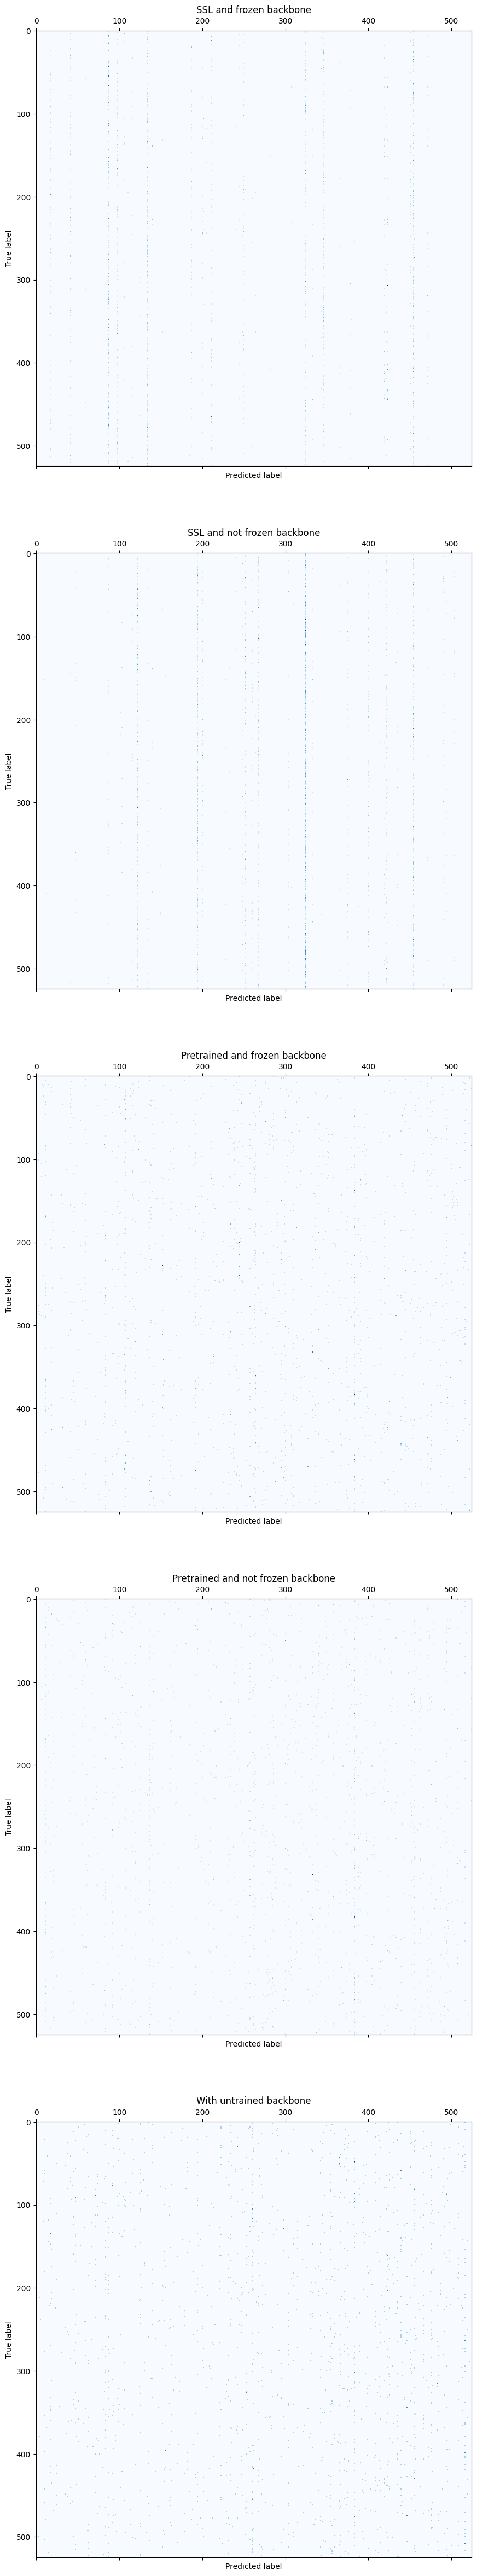

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(60, 60))
for i, ax in enumerate(axs):
    ax.matshow(confusion_matrices[i], cmap=plt.cm.Blues)
    ax.set_title(titles[i])
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.show()